In [74]:
import numpy as np
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from pathlib import Path
import timeit
import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.decomposition import PCA

In [75]:
path = str(Path().resolve())+'\csv'
df = pd.read_csv(path+"/hourly_consumption.csv")

df.localminute = df.localminute.str.slice(0,19)
df.localminute = pd.to_datetime(df.localminute, infer_datetime_format = True, 
                                      format = "%Y/%m/%d %I:%M:%S %p");
headers = ["dataid", "totoalConsumption", "morningMean", "morningSTD", "noonMean",
          "noonSTD", "nightMean", "nightSTD"]
df.localminute = df.localminute.map(lambda x:x.replace(minute=0, second=0));
currentID = df.iloc[0]['dataid']
baseTime = df.iloc[0]['localminute'] 
featuresList = []
morningConsumption = []
noonConsumption = []
nightConsumption = []
totoalConsumption = 0
currentMorning = 0
currentNoon = 0
currentNight = 0
prevDay = 0

In [76]:
# Feature Extraction
for row in df.itertuples():
    time_diff = str(row.localminute - baseTime)
    hrs_diff = int(time_diff.split(" ")[2][:2])
    day_diff = int((time_diff.split(" ")[0]))
    if (day_diff != prevDay):
        morningConsumption.append(currentMorning)
        noonConsumption.append(currentNoon)
        nightConsumption.append(currentNight)
        prevDay = day_diff
        currentMorning = 0
        currentNoon = 0
        currentNight = 0
        
    if (currentID != row.dataid):
        features = []
        morningMean = np.mean(morningConsumption)
        morningSTD = np.std(morningConsumption)
        noonMean = np.mean(noonConsumption)
        noonSTD = np.std(noonConsumption)
        nightMean = np.mean(nightConsumption)
        nightSTD = np.std(nightConsumption)
        features.append(currentID)
        features.append(totoalConsumption)
        features.append(morningMean)
        features.append(morningSTD)
        features.append(noonMean)
        features.append(noonSTD)
        features.append(nightMean)
        features.append(nightSTD)
        featuresList.append(features)
        
        morningConsumption = []
        noonConsumption = []
        nightConsumption = []
        totoalConsumption = 0
        currentID = row.dataid
    
    totoalConsumption = totoalConsumption + int(row.meter_value)
    if (hrs_diff >= 6 and hrs_diff < 9):
        currentMorning = currentMorning + int(row.meter_value)
    elif (hrs_diff >= 11 and hrs_diff < 14):
        currentNoon = currentNoon + int(row.meter_value)
    elif (hrs_diff >= 17 and hrs_diff < 20):
        currentNight = currentNight + int(row.meter_value)

morningConsumption.append(currentMorning)
noonConsumption.append(currentNoon)
nightConsumption.append(currentNight)
morningMean = np.mean(morningConsumption)
morningSTD = np.std(morningConsumption)
noonMean = np.mean(noonConsumption)
noonSTD = np.std(noonConsumption)
nightMean = np.mean(nightConsumption)
nightSTD = np.std(nightConsumption)
features = []

features.append(currentID)
features.append(totoalConsumption)
features.append(morningMean)
features.append(morningSTD)
features.append(noonMean)
features.append(noonSTD)
features.append(nightMean)
features.append(nightSTD)
featuresList.append(features)

featureFrame = pd.DataFrame(featuresList)
featureFrame.to_csv(path + '/reading_features.csv', header=headers, index=None)

In [83]:
df = pd.read_csv(path+"/reading_features.csv")
featureNames = ["totoalConsumption", "morningMean", "noonMean", "nightMean"]
kmeans = KMeans(n_clusters=3).fit(df[featureNames])
df.insert(loc=0, column="classification", value=kmeans.labels_)
df.to_csv(path + '/reading_features_classification.csv', index=None)

Text(0,0.5,'Morning Average Consumption')

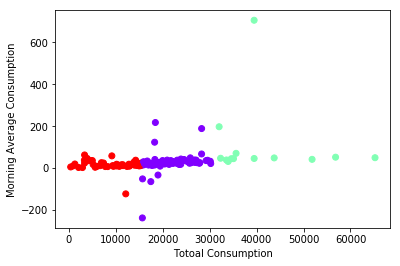

In [78]:
df_array = df.values
plt.scatter(df_array[:,2],df_array[:,3], c=kmeans.labels_, cmap='rainbow')  
plt.xlabel('Totoal Consumption')
plt.ylabel('Morning Average Consumption')

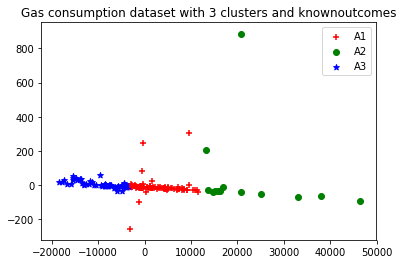

In [79]:
pca = PCA(n_components=2).fit(df[featureNames])
pca_2d = pca.transform(df[featureNames])
for i in range(0, pca_2d.shape[0]):
    if df.classification[i] == 0:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif df.classification[i] == 1:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif df.classification[i] == 2:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
pl.legend([c1, c2, c3], ['A1', 'A2','A3'])
pl.title('Gas consumption dataset with 3 clusters and knownoutcomes')
pl.show()